<a href="https://colab.research.google.com/github/otausendschoen/Image_Classification_Diffusion-Augmentation/blob/main/05_Claudia50_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/otausendschoen/Image_Classification_Diffusion-Augmentation/blob/main/03_10%25Synthetic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.3/489.3 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.2
    Uninstalling huggingface-hub-0.31.2:
      Successfully uninstalled huggingface-hub-0.31.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms, models
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
from collections import Counter, defaultdict
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sns
import zipfile

In [4]:
# Set random seeds for reproducibility
random.seed(8)
np.random.seed(8)
torch.manual_seed(8)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(8)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Loading the dataset

Changed this to the EuroSAT ds available on hugging face dataset to save loading time.

In [5]:
# Load the EuroSAT dataset directly from Hugging Face
print("Loading dataset...")
dataset = load_dataset("jonathan-roberts1/EuroSAT")
print(dataset)

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

(…)-00000-of-00001-26e80b6de2d4dca7.parquet:   0%|          | 0.00/88.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})


In [6]:
dataset["train"] = dataset["train"].shuffle(seed=42).select(
    range(len(dataset["train"]) // 2)
)

In [7]:
# Create train-validation split
train_val_dataset = dataset["train"]
train_indices, val_indices = train_test_split(
    range(len(train_val_dataset)),
    test_size=0.2,
    stratify=[item['label'] for item in train_val_dataset],
    random_state=8
)

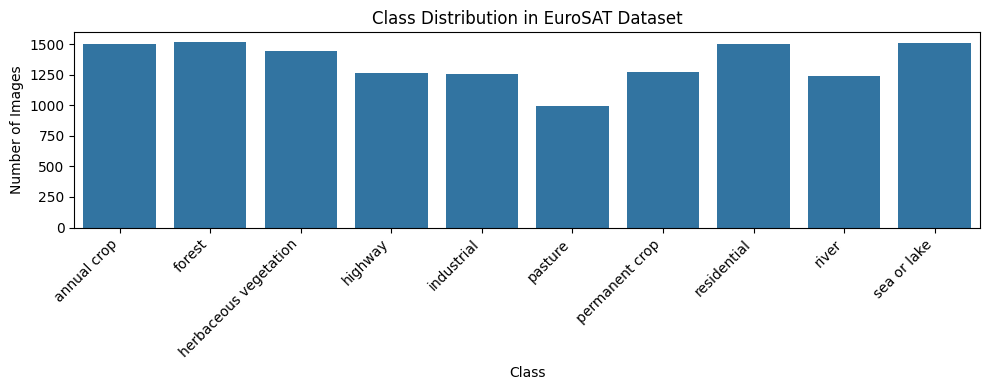

,Class,Percentage,Number of Images
0,annual crop,11.12%,1501
1,forest,11.26%,1520
2,herbaceous vegetation,10.68%,1442
3,highway,9.36%,1263
4,industrial,9.31%,1257
5,pasture,7.38%,996
6,permanent crop,9.41%,1271
7,residential,11.13%,1502
8,river,9.16%,1237
9,sea or lake,11.19%,1511


In [8]:
# Checking Ratios

from collections import Counter
import pandas as pd

# Count labels
labels = dataset["train"]["label"]
label_names = dataset["train"].features["label"].names
label_counts = Counter(labels)

# Build DataFrame for display
total = sum(label_counts.values())
df = pd.DataFrame([
    {"Class": label_names[i],
     "Percentage": f"{(count / total) * 100:.2f}%",
     "Number of Images": count}
    for i, count in sorted(label_counts.items())
])

# Display as a table
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.barplot(data=df, x="Class", y="Number of Images")
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in EuroSAT Dataset")
plt.tight_layout()
plt.show()

# Show DataFrame
import IPython.display as disp
disp.display(df)

Images were preprocessed using a standard pipeline for transfer learning with ImageNet-pretrained models. First, the EuroSAT images were resized from their native 64×64 resolution to 224×224 pixels to match the input requirements of the Wide ResNet50 architecture. The pixel values were then converted to tensors and normalized using ImageNet's channel-wise mean (0.485, 0.456, 0.406) and standard deviation (0.229, 0.224, 0.225) to ensure compatibility with the pretrained weights. This preprocessing approach is critical when leveraging transfer learning, as it aligns the input distribution with what the pretrained network expects, allowing effective feature extraction from the early convolutional layers despite the domain shift between natural images and satellite imagery.

In [9]:
# Function to visualize class distribution
def plot_class_distribution(labels, title, label_names=None):
    if label_names is None:
        label_names = dataset["train"].features["label"].names

    # Count and build DataFrame
    label_counts = Counter(labels)
    total = sum(label_counts.values())
    df = pd.DataFrame([
        {
            "Class": label_names[i] if isinstance(i, int) else i,
            "Percentage": f"{(count / total) * 100:.2f}%",
            "Number of Images": count
        }
        for i, count in sorted(label_counts.items())
    ])

    # Plot bar chart
    plt.figure(figsize=(10, 4))
    sns.barplot(data=df, x="Class", y="Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Display the table
    return df

We define the ResNet-18 model

In [10]:
# Define the ResNet-18 model
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(ResNet18Classifier, self).__init__()

        # For newer PyTorch versions (1.13+)
        try:
            self.model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        except:
            # Fallback for older versions
            self.model = models.resnet18(pretrained=pretrained)

        # Replacing the final fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In our implementation, we created a custom EuroSATDataset class that inherits from PyTorch's Dataset, providing an efficient interface between our raw satellite imagery and the training pipeline. This class handles the application of image transformations and maintains the train-validation split through indexing, allowing flexible access to different subsets of the data. We then instantiated separate training and validation datasets with their respective transformations, and wrapped them in DataLoaders with a batch size of 32. The training loader incorporates shuffling to improve model generalization, while the validation loader maintains deterministic ordering. This approach enables efficient batched processing and parallelized data loading, which is essential for training deep convolutional networks like Wide ResNet50 on large image datasets.

In [11]:
# Create PyTorch datasets
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices=None, transform=None):
        self.dataset = dataset
        self.indices = indices if indices is not None else range(len(dataset))
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.dataset[self.indices[idx]]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

In [13]:
# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

Our implementation establishes a comprehensive training framework with integrated early stopping to prevent overfitting on the EuroSAT dataset. The training loop executes up to 30 epochs, with patience set to 5 epochs for early termination if validation accuracy fails to improve. Within each epoch, we conduct a full training pass using our train_one_epoch function, followed by validation with the validate function, while systematically applying learning rate adjustments via the cosine annealing scheduler. Performance metrics including loss, accuracy, and F1-score are tracked for both training and validation sets and stored in a history dictionary for subsequent analysis. We save the model weights only when validation accuracy improves, maintaining the best-performing configuration throughout training.

In [14]:
# Training loop function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=30, patience=7, save_path=None):
    best_val_acc = 0
    counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Create the directory if it doesn't exist
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)


    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Print statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if save_path:
                torch.save(model.state_dict(), save_path)
            counter = 0
        else:
            counter += 1

        # Early stopping
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print best validation accuracy
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    return history, best_val_acc

In [15]:
# Function to create dataset with specific synthetic data ratio
def create_synthetic_dataset(train_dataset, synthetic_full, synth_prop, seed=8):
    random.seed(seed)

    # Get all original labels
    orig_labels = [label for _, label in train_dataset]
    orig_counts = Counter(orig_labels)

    # Build a map class_id -> list of synthetic indices
    class_to_syn_idxs = defaultdict(list)
    for idx, (_, lbl) in enumerate(synthetic_full):
        class_to_syn_idxs[lbl].append(idx)

    # For each class, sample synth_prop of the original count from synthetic pool
    syn_sample_idxs = []
    for cls, cnt in orig_counts.items():
        num_to_add = int(synth_prop * cnt)
        available = class_to_syn_idxs[cls]
        if len(available) < num_to_add:
            num_to_add = len(available)
        syn_sample_idxs += random.sample(available, num_to_add)

    # Create a Subset of synthetic data
    synthetic_subset = Subset(synthetic_full, syn_sample_idxs)

    # Combine original train + synthetic subset
    combined_train = ConcatDataset([train_dataset, synthetic_subset])

    print(f" → Original train samples: {len(train_dataset)}")
    print(f" → Synthetic added:       {len(synthetic_subset)}")
    print(f" → Total combined:        {len(combined_train)}")

    return combined_train

Below the full training loop for all configurations

- Using the full EuroSAT dataset:
  - No change
  - Geometric augmentation
  - 5% Synth
  - 10% Synth
  - 20% Synth
  - 30% Synth
  - 40% Synth
  - 50% Synth

Extracting synthetic dataset...
Extraction complete.

Running experiment: 5% Synthetic Data
 → Original train samples: 10800
 → Synthetic added:       535
 → Total combined:        11335


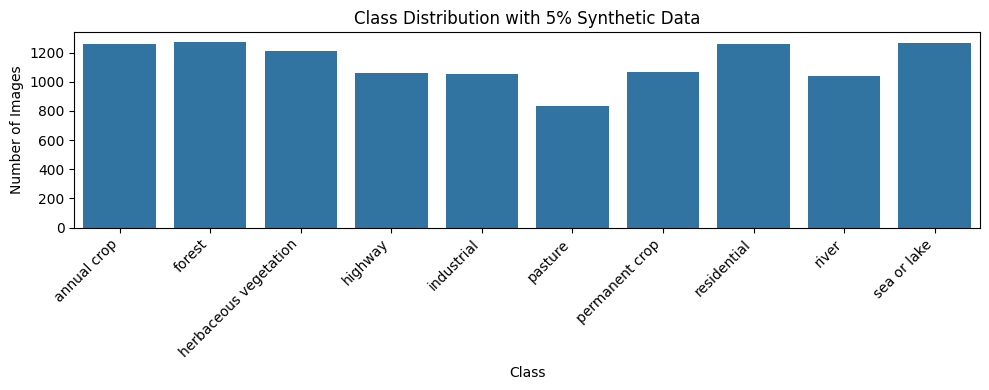

                   Class Percentage  Number of Images
0            annual crop     11.12%              1261
1                 forest     11.26%              1276
2  herbaceous vegetation     10.68%              1211
3                highway      9.35%              1060
4             industrial      9.31%              1055
5                pasture      7.38%               836
6         permanent crop      9.41%              1067
7            residential     11.13%              1262
8                  river      9.16%              1038
9            sea or lake     11.20%              1269
Epoch 1/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.3324, Train Acc: 0.8936, Train F1: 0.8934
Val Loss: 0.1383, Val Acc: 0.9522, Val F1: 0.9520
Epoch 2/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1094, Train Acc: 0.9655, Train F1: 0.9655
Val Loss: 0.1006, Val Acc: 0.9648, Val F1: 0.9648
Epoch 3/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0582, Train Acc: 0.9824, Train F1: 0.9824
Val Loss: 0.0876, Val Acc: 0.9704, Val F1: 0.9703
Epoch 4/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0420, Train Acc: 0.9880, Train F1: 0.9880
Val Loss: 0.0784, Val Acc: 0.9744, Val F1: 0.9744
Epoch 5/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0223, Train Acc: 0.9941, Train F1: 0.9941
Val Loss: 0.0825, Val Acc: 0.9744, Val F1: 0.9744
Epoch 6/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0356, Train Acc: 0.9884, Train F1: 0.9885
Val Loss: 0.0856, Val Acc: 0.9715, Val F1: 0.9715
Epoch 7/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0250, Train Acc: 0.9924, Train F1: 0.9924
Val Loss: 0.0776, Val Acc: 0.9748, Val F1: 0.9748
Epoch 8/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0087, Train Acc: 0.9981, Train F1: 0.9981
Val Loss: 0.0702, Val Acc: 0.9800, Val F1: 0.9800
Epoch 9/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0190, Train Acc: 0.9964, Train F1: 0.9964
Val Loss: 0.0755, Val Acc: 0.9774, Val F1: 0.9773
Epoch 10/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0125, Train Acc: 0.9974, Train F1: 0.9974
Val Loss: 0.0806, Val Acc: 0.9781, Val F1: 0.9781
Epoch 11/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0140, Train Acc: 0.9967, Train F1: 0.9967
Val Loss: 0.0723, Val Acc: 0.9804, Val F1: 0.9804
Epoch 12/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0041, Train Acc: 0.9994, Train F1: 0.9994
Val Loss: 0.0729, Val Acc: 0.9781, Val F1: 0.9781
Epoch 13/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0028, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0708, Val Acc: 0.9822, Val F1: 0.9822
Epoch 14/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0023, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0763, Val Acc: 0.9793, Val F1: 0.9793
Epoch 15/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0031, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0753, Val Acc: 0.9807, Val F1: 0.9807
Epoch 16/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0711, Val Acc: 0.9785, Val F1: 0.9785
Epoch 17/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0724, Val Acc: 0.9800, Val F1: 0.9800
Epoch 18/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0020, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0746, Val Acc: 0.9800, Val F1: 0.9800
Epoch 19/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0026, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0764, Val Acc: 0.9781, Val F1: 0.9781
Epoch 20/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0018, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0729, Val Acc: 0.9811, Val F1: 0.9811
Early stopping at epoch 20


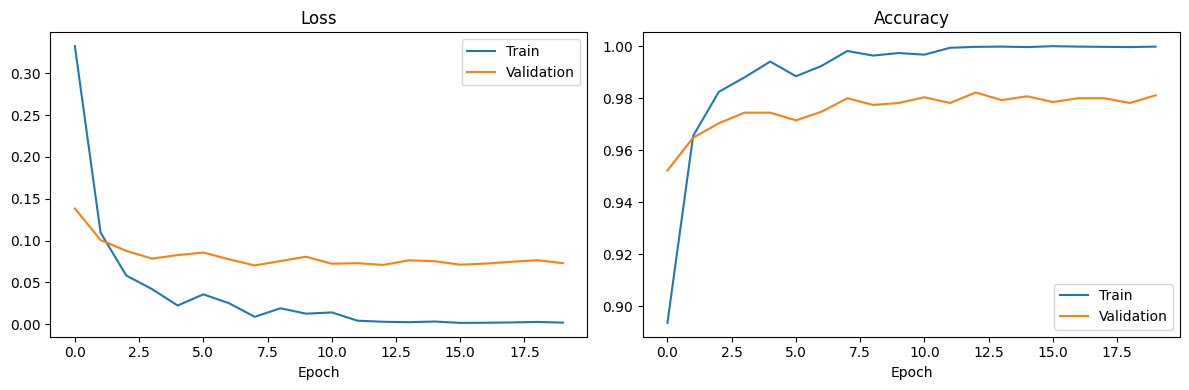

Best validation accuracy: 0.9822

Running experiment: 10% Synthetic Data
 → Original train samples: 10800
 → Synthetic added:       1075
 → Total combined:        11875


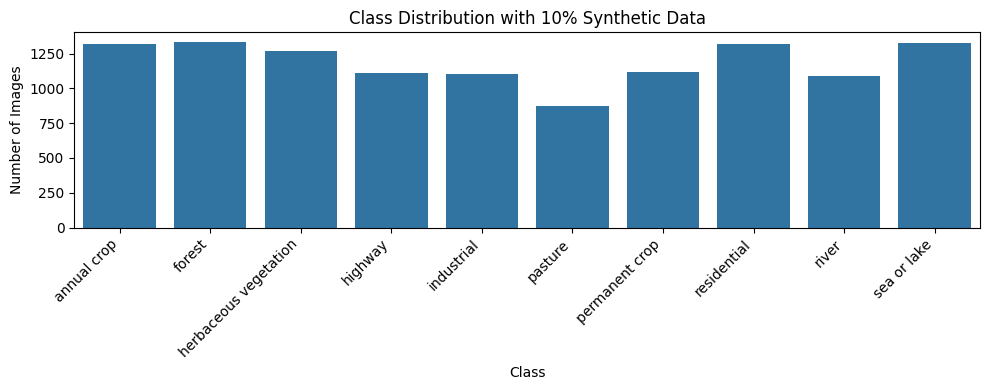

                   Class Percentage  Number of Images
0            annual crop     11.12%              1321
1                 forest     11.26%              1337
2  herbaceous vegetation     10.69%              1269
3                highway      9.36%              1111
4             industrial      9.31%              1105
5                pasture      7.38%               876
6         permanent crop      9.41%              1118
7            residential     11.13%              1322
8                  river      9.15%              1087
9            sea or lake     11.19%              1329
Epoch 1/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.3537, Train Acc: 0.8909, Train F1: 0.8908
Val Loss: 0.1259, Val Acc: 0.9578, Val F1: 0.9574
Epoch 2/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1194, Train Acc: 0.9617, Train F1: 0.9617
Val Loss: 0.1430, Val Acc: 0.9519, Val F1: 0.9518
Epoch 3/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0764, Train Acc: 0.9752, Train F1: 0.9752
Val Loss: 0.0824, Val Acc: 0.9737, Val F1: 0.9737
Epoch 4/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0422, Train Acc: 0.9879, Train F1: 0.9879
Val Loss: 0.1117, Val Acc: 0.9619, Val F1: 0.9616
Epoch 5/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0223, Train Acc: 0.9945, Train F1: 0.9945
Val Loss: 0.0645, Val Acc: 0.9822, Val F1: 0.9822
Epoch 6/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0154, Train Acc: 0.9962, Train F1: 0.9962
Val Loss: 0.0751, Val Acc: 0.9767, Val F1: 0.9766
Epoch 7/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0151, Train Acc: 0.9960, Train F1: 0.9960
Val Loss: 0.0790, Val Acc: 0.9756, Val F1: 0.9755
Epoch 8/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0113, Train Acc: 0.9977, Train F1: 0.9977
Val Loss: 0.0645, Val Acc: 0.9811, Val F1: 0.9811
Epoch 9/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0061, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0760, Val Acc: 0.9785, Val F1: 0.9786
Epoch 10/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0054, Train Acc: 0.9989, Train F1: 0.9989
Val Loss: 0.0588, Val Acc: 0.9841, Val F1: 0.9841
Epoch 11/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0041, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0585, Val Acc: 0.9815, Val F1: 0.9814
Epoch 12/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0578, Val Acc: 0.9848, Val F1: 0.9848
Epoch 13/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0020, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0636, Val Acc: 0.9822, Val F1: 0.9822
Epoch 14/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0619, Val Acc: 0.9830, Val F1: 0.9830
Epoch 15/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0582, Val Acc: 0.9837, Val F1: 0.9837
Epoch 16/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0620, Val Acc: 0.9830, Val F1: 0.9829
Epoch 17/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0608, Val Acc: 0.9826, Val F1: 0.9826
Epoch 18/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0590, Val Acc: 0.9830, Val F1: 0.9830
Epoch 19/30


Training:   0%|          | 0/186 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0563, Val Acc: 0.9837, Val F1: 0.9837
Early stopping at epoch 19


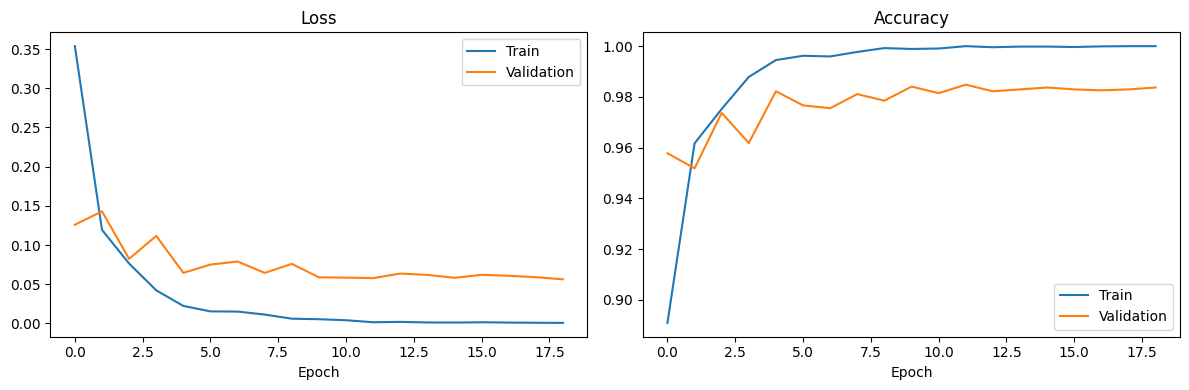

Best validation accuracy: 0.9848

Running experiment: 20% Synthetic Data
 → Original train samples: 10800
 → Synthetic added:       2156
 → Total combined:        12956


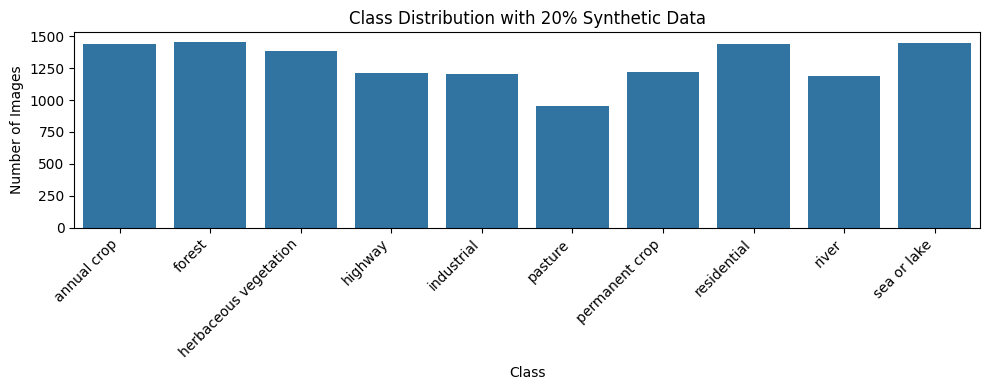

                   Class Percentage  Number of Images
0            annual crop     11.12%              1441
1                 forest     11.26%              1459
2  herbaceous vegetation     10.68%              1384
3                highway      9.35%              1212
4             industrial      9.31%              1206
5                pasture      7.38%               956
6         permanent crop      9.42%              1220
7            residential     11.13%              1442
8                  river      9.15%              1186
9            sea or lake     11.19%              1450
Epoch 1/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.3990, Train Acc: 0.8718, Train F1: 0.8718
Val Loss: 0.1226, Val Acc: 0.9593, Val F1: 0.9594
Epoch 2/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1354, Train Acc: 0.9565, Train F1: 0.9565
Val Loss: 0.1097, Val Acc: 0.9589, Val F1: 0.9588
Epoch 3/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0747, Train Acc: 0.9755, Train F1: 0.9755
Val Loss: 0.0981, Val Acc: 0.9652, Val F1: 0.9653
Epoch 4/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0380, Train Acc: 0.9891, Train F1: 0.9891
Val Loss: 0.0793, Val Acc: 0.9756, Val F1: 0.9756
Epoch 5/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0282, Train Acc: 0.9921, Train F1: 0.9921
Val Loss: 0.1175, Val Acc: 0.9656, Val F1: 0.9656
Epoch 6/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0210, Train Acc: 0.9939, Train F1: 0.9939
Val Loss: 0.0838, Val Acc: 0.9752, Val F1: 0.9752
Epoch 7/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0122, Train Acc: 0.9976, Train F1: 0.9976
Val Loss: 0.0734, Val Acc: 0.9756, Val F1: 0.9755
Epoch 8/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0058, Train Acc: 0.9989, Train F1: 0.9989
Val Loss: 0.0839, Val Acc: 0.9748, Val F1: 0.9748
Epoch 9/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0065, Train Acc: 0.9988, Train F1: 0.9988
Val Loss: 0.0683, Val Acc: 0.9796, Val F1: 0.9796
Epoch 10/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0043, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0657, Val Acc: 0.9778, Val F1: 0.9778
Epoch 11/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0048, Train Acc: 0.9990, Train F1: 0.9990
Val Loss: 0.0611, Val Acc: 0.9800, Val F1: 0.9800
Epoch 12/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0021, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0620, Val Acc: 0.9800, Val F1: 0.9800
Epoch 13/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0624, Val Acc: 0.9807, Val F1: 0.9807
Epoch 14/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0600, Val Acc: 0.9811, Val F1: 0.9811
Epoch 15/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0585, Val Acc: 0.9815, Val F1: 0.9815
Epoch 16/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0607, Val Acc: 0.9796, Val F1: 0.9796
Epoch 17/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0592, Val Acc: 0.9826, Val F1: 0.9826
Epoch 18/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0601, Val Acc: 0.9815, Val F1: 0.9815
Epoch 19/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0602, Val Acc: 0.9811, Val F1: 0.9811
Epoch 20/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0584, Val Acc: 0.9815, Val F1: 0.9815
Epoch 21/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0605, Val Acc: 0.9815, Val F1: 0.9815
Epoch 22/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0606, Val Acc: 0.9815, Val F1: 0.9815
Epoch 23/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0609, Val Acc: 0.9804, Val F1: 0.9804
Epoch 24/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0608, Val Acc: 0.9833, Val F1: 0.9833
Epoch 25/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0591, Val Acc: 0.9830, Val F1: 0.9829
Epoch 26/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0592, Val Acc: 0.9826, Val F1: 0.9826
Epoch 27/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0710, Val Acc: 0.9800, Val F1: 0.9800
Epoch 28/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0107, Train Acc: 0.9964, Train F1: 0.9964
Val Loss: 0.0905, Val Acc: 0.9730, Val F1: 0.9730
Epoch 29/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0117, Train Acc: 0.9964, Train F1: 0.9964
Val Loss: 0.0715, Val Acc: 0.9785, Val F1: 0.9785
Epoch 30/30


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0037, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0746, Val Acc: 0.9785, Val F1: 0.9785


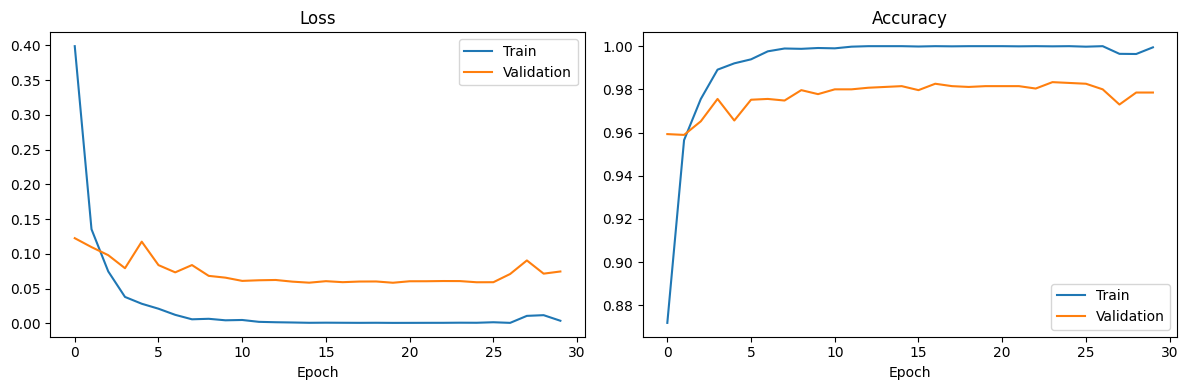

Best validation accuracy: 0.9833

Running experiment: 30% Synthetic Data
 → Original train samples: 10800
 → Synthetic added:       3236
 → Total combined:        14036


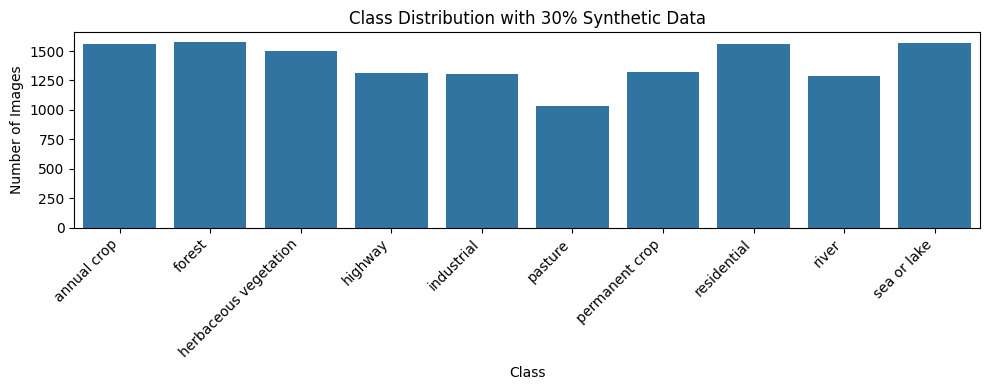

                   Class Percentage  Number of Images
0            annual crop     11.12%              1561
1                 forest     11.26%              1580
2  herbaceous vegetation     10.69%              1500
3                highway      9.35%              1313
4             industrial      9.30%              1306
5                pasture      7.38%              1036
6         permanent crop      9.42%              1322
7            residential     11.13%              1562
8                  river      9.16%              1285
9            sea or lake     11.19%              1571
Epoch 1/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.4281, Train Acc: 0.8582, Train F1: 0.8577
Val Loss: 0.1106, Val Acc: 0.9652, Val F1: 0.9651
Epoch 2/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1519, Train Acc: 0.9514, Train F1: 0.9514
Val Loss: 0.1136, Val Acc: 0.9637, Val F1: 0.9633
Epoch 3/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0849, Train Acc: 0.9739, Train F1: 0.9739
Val Loss: 0.0976, Val Acc: 0.9722, Val F1: 0.9723
Epoch 4/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0470, Train Acc: 0.9861, Train F1: 0.9861
Val Loss: 0.0970, Val Acc: 0.9726, Val F1: 0.9726
Epoch 5/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0300, Train Acc: 0.9917, Train F1: 0.9917
Val Loss: 0.1225, Val Acc: 0.9678, Val F1: 0.9679
Epoch 6/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0263, Train Acc: 0.9930, Train F1: 0.9930
Val Loss: 0.0751, Val Acc: 0.9778, Val F1: 0.9777
Epoch 7/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0126, Train Acc: 0.9969, Train F1: 0.9969
Val Loss: 0.0726, Val Acc: 0.9778, Val F1: 0.9778
Epoch 8/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0122, Train Acc: 0.9965, Train F1: 0.9965
Val Loss: 0.1036, Val Acc: 0.9674, Val F1: 0.9673
Epoch 9/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 0.9979, Train F1: 0.9979
Val Loss: 0.0753, Val Acc: 0.9796, Val F1: 0.9796
Epoch 10/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0046, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0764, Val Acc: 0.9785, Val F1: 0.9785
Epoch 11/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0024, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0791, Val Acc: 0.9781, Val F1: 0.9781
Epoch 12/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0040, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0812, Val Acc: 0.9770, Val F1: 0.9769
Epoch 13/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0018, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0757, Val Acc: 0.9785, Val F1: 0.9785
Epoch 14/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0741, Val Acc: 0.9815, Val F1: 0.9815
Epoch 15/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0708, Val Acc: 0.9826, Val F1: 0.9825
Epoch 16/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0745, Val Acc: 0.9819, Val F1: 0.9818
Epoch 17/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0730, Val Acc: 0.9811, Val F1: 0.9811
Epoch 18/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0731, Val Acc: 0.9804, Val F1: 0.9803
Epoch 19/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0734, Val Acc: 0.9811, Val F1: 0.9810
Epoch 20/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0723, Val Acc: 0.9833, Val F1: 0.9833
Epoch 21/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0696, Val Acc: 0.9837, Val F1: 0.9837
Epoch 22/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0716, Val Acc: 0.9830, Val F1: 0.9829
Epoch 23/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0747, Val Acc: 0.9822, Val F1: 0.9822
Epoch 24/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0738, Val Acc: 0.9822, Val F1: 0.9822
Epoch 25/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0723, Val Acc: 0.9819, Val F1: 0.9818
Epoch 26/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0729, Val Acc: 0.9822, Val F1: 0.9822
Epoch 27/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0028, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0783, Val Acc: 0.9781, Val F1: 0.9781
Epoch 28/30


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0052, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0818, Val Acc: 0.9763, Val F1: 0.9763
Early stopping at epoch 28


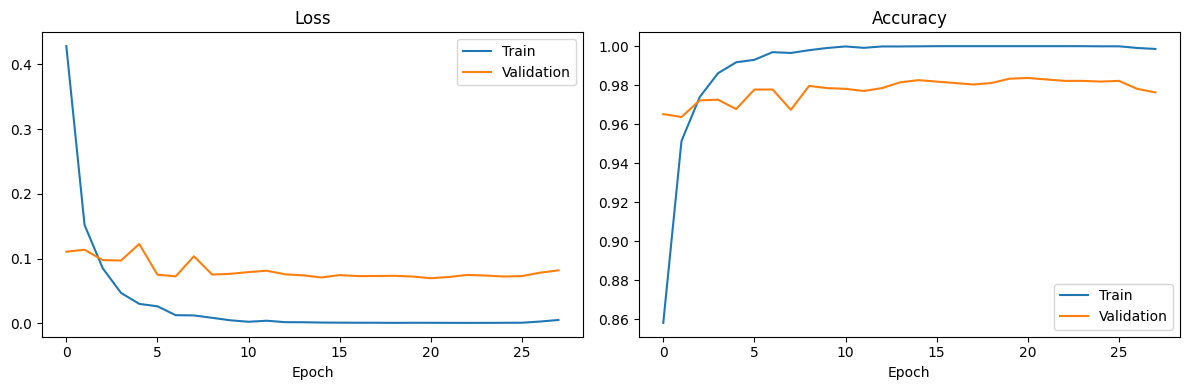

Best validation accuracy: 0.9837

Running experiment: 40% Synthetic Data
 → Original train samples: 10800
 → Synthetic added:       4315
 → Total combined:        15115


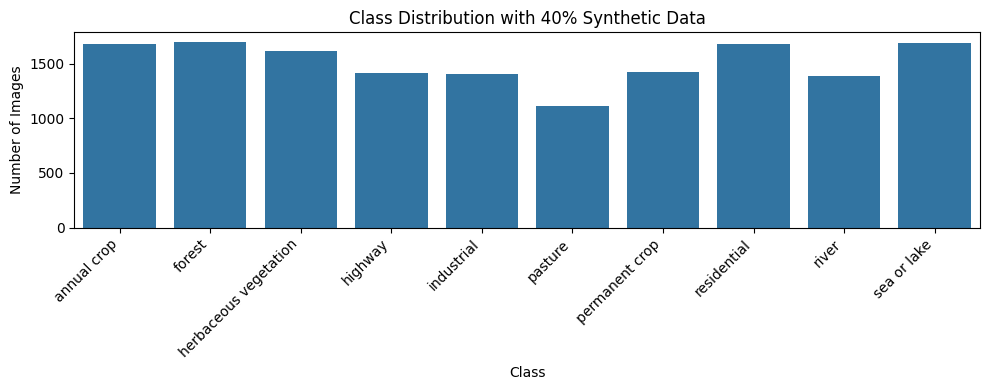

                   Class Percentage  Number of Images
0            annual crop     11.12%              1681
1                 forest     11.26%              1702
2  herbaceous vegetation     10.68%              1615
3                highway      9.35%              1414
4             industrial      9.31%              1407
5                pasture      7.38%              1115
6         permanent crop      9.41%              1423
7            residential     11.13%              1682
8                  river      9.16%              1384
9            sea or lake     11.19%              1692
Epoch 1/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.4210, Train Acc: 0.8625, Train F1: 0.8622
Val Loss: 0.1092, Val Acc: 0.9637, Val F1: 0.9637
Epoch 2/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1606, Train Acc: 0.9475, Train F1: 0.9475
Val Loss: 0.0952, Val Acc: 0.9693, Val F1: 0.9692
Epoch 3/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0813, Train Acc: 0.9739, Train F1: 0.9739
Val Loss: 0.1090, Val Acc: 0.9626, Val F1: 0.9627
Epoch 4/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0650, Train Acc: 0.9811, Train F1: 0.9811
Val Loss: 0.1197, Val Acc: 0.9611, Val F1: 0.9611
Epoch 5/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0295, Train Acc: 0.9919, Train F1: 0.9919
Val Loss: 0.0910, Val Acc: 0.9670, Val F1: 0.9671
Epoch 6/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0273, Train Acc: 0.9925, Train F1: 0.9925
Val Loss: 0.0807, Val Acc: 0.9748, Val F1: 0.9748
Epoch 7/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0159, Train Acc: 0.9964, Train F1: 0.9964
Val Loss: 0.0930, Val Acc: 0.9685, Val F1: 0.9685
Epoch 8/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0211, Train Acc: 0.9942, Train F1: 0.9942
Val Loss: 0.0877, Val Acc: 0.9719, Val F1: 0.9718
Epoch 9/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0124, Train Acc: 0.9967, Train F1: 0.9967
Val Loss: 0.0810, Val Acc: 0.9774, Val F1: 0.9774
Epoch 10/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0062, Train Acc: 0.9985, Train F1: 0.9985
Val Loss: 0.0757, Val Acc: 0.9770, Val F1: 0.9770
Epoch 11/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0755, Val Acc: 0.9756, Val F1: 0.9755
Epoch 12/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0024, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0662, Val Acc: 0.9793, Val F1: 0.9792
Epoch 13/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0020, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0727, Val Acc: 0.9767, Val F1: 0.9766
Epoch 14/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0680, Val Acc: 0.9789, Val F1: 0.9789
Epoch 15/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0697, Val Acc: 0.9778, Val F1: 0.9778
Epoch 16/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0699, Val Acc: 0.9804, Val F1: 0.9803
Epoch 17/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0659, Val Acc: 0.9796, Val F1: 0.9796
Epoch 18/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0661, Val Acc: 0.9804, Val F1: 0.9804
Epoch 19/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0666, Val Acc: 0.9811, Val F1: 0.9811
Epoch 20/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0685, Val Acc: 0.9800, Val F1: 0.9800
Epoch 21/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0653, Val Acc: 0.9804, Val F1: 0.9803
Epoch 22/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0651, Val Acc: 0.9789, Val F1: 0.9789
Epoch 23/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0654, Val Acc: 0.9804, Val F1: 0.9804
Epoch 24/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0655, Val Acc: 0.9804, Val F1: 0.9804
Epoch 25/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0673, Val Acc: 0.9826, Val F1: 0.9825
Epoch 26/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0689, Val Acc: 0.9789, Val F1: 0.9789
Epoch 27/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0026, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0776, Val Acc: 0.9778, Val F1: 0.9778
Epoch 28/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0125, Train Acc: 0.9974, Train F1: 0.9974
Val Loss: 0.0697, Val Acc: 0.9811, Val F1: 0.9811
Epoch 29/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.9989, Train F1: 0.9989
Val Loss: 0.1072, Val Acc: 0.9689, Val F1: 0.9688
Epoch 30/30


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0169, Train Acc: 0.9954, Train F1: 0.9954
Val Loss: 0.0822, Val Acc: 0.9770, Val F1: 0.9770


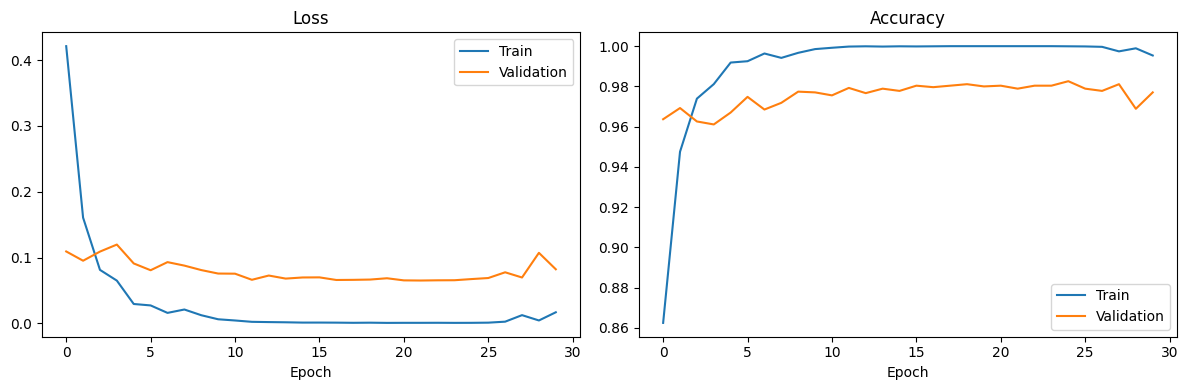

Best validation accuracy: 0.9826


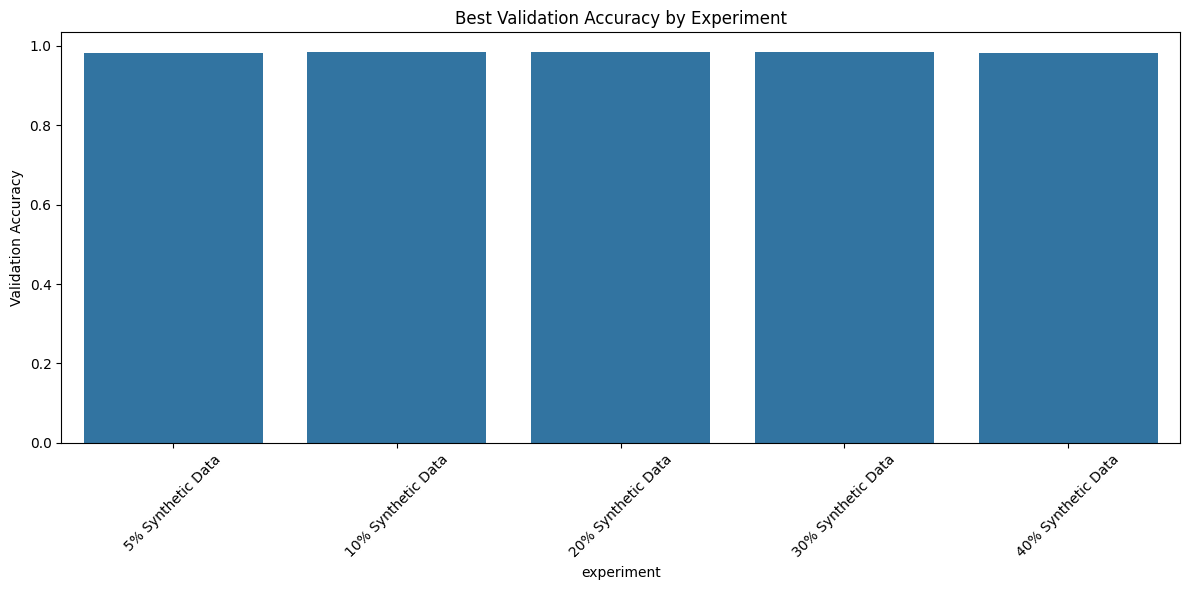

Final results:
           experiment  best_val_acc
0   5% Synthetic Data      0.982222
1  10% Synthetic Data      0.984815
2  20% Synthetic Data      0.983333
3  30% Synthetic Data      0.983704
4  40% Synthetic Data      0.982593


In [ ]:
# Main execution
def run_experiments():
    # Define transformations

    # 1. Basic transformation (no augmentation)
    transform_basic = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Geometric augmentation
    transform_geometric = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Standard test transformation (no augmentation)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create base datasets
    base_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_basic)
    geo_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_geometric)
    val_dataset = EuroSATDataset(train_val_dataset, val_indices, transform_test)

    # Create validation dataloader (common for all experiments)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    # Extract synthetic dataset
    print("Extracting synthetic dataset...")
    zip_path = "/content/drive/MyDrive/data/ddpm-generated-images_50.zip"
    extract_path = "/content/ddpm_generated"

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
    except Exception as e:
        print(f"Error extracting synthetic dataset: {e}")
        print("Make sure the path is correct and the file exists")
        return

    # Load synthetic data
    synthetic_full = ImageFolder(
        root=extract_path,
        transform=transform_basic
    )

    # Define different augmentation ratios
    synth_ratios = [0.05,0.1,0.2,0.3,0.4]

    # Store results
    all_results = {
        'experiment': [],
        'best_val_acc': []
    }

    # # Run experiment with no augmentation
    # print("\n=========================================")
    # print("Running experiment: No Augmentation")
    # print("=========================================")

    # train_loader = DataLoader(base_train_dataset, batch_size=64, shuffle=True, num_workers=0)

    # model = ResNet18Classifier(num_classes=10).to(device)
    # criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    # _, best_acc = train_model(
    #     model, train_loader, val_loader, criterion, optimizer, scheduler,
    #     save_path="/content/drive/MyDrive/models/resnet18_no_aug.pth"
    # )

    # all_results['experiment'].append("No Augmentation")
    # all_results['best_val_acc'].append(best_acc)

    # # Run experiment with geometric augmentation
    # print("\n=========================================")
    # print("Running experiment: Geometric Augmentation")
    # print("=========================================")

    # train_loader = DataLoader(geo_train_dataset, batch_size=64, shuffle=True, num_workers=0)

    # model = ResNet18Classifier(num_classes=10).to(device)
    # criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    # _, best_acc = train_model(
    #     model, train_loader, val_loader, criterion, optimizer, scheduler,
    #     save_path="/content/drive/MyDrive/models/resnet18_geo_aug.pth"
    # )

    # all_results['experiment'].append("Geometric Augmentation")
    # all_results['best_val_acc'].append(best_acc)

    # Run experiments with different synthetic data ratios
    for ratio in synth_ratios:
        print(f"\n=========================================")
        print(f"Running experiment: {int(ratio*100)}% Synthetic Data")
        print(f"=========================================")

        # Create dataset with synthetic data
        combined_dataset = create_synthetic_dataset(base_train_dataset, synthetic_full, ratio)
        train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=0)

        # Check class distribution
        combined_labels = [label for _, label in combined_dataset]
        df = plot_class_distribution(combined_labels, f"Class Distribution with {int(ratio*100)}% Synthetic Data")
        print(df)

        model = ResNet18Classifier(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

        _, best_acc = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            save_path=f"/content/drive/MyDrive/models/resnet18_synth_{int(ratio*100)}pct.pth"
        )

        all_results['experiment'].append(f"{int(ratio*100)}% Synthetic Data")
        all_results['best_val_acc'].append(best_acc)

    # Plot final comparison
    results_df = pd.DataFrame(all_results)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='experiment', y='best_val_acc')
    plt.title('Best Validation Accuracy by Experiment')
    plt.ylabel('Validation Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("Final results:")
    print(results_df)

    return results_df

# Run all experiments
if __name__ == "__main__":
    results = run_experiments()

# Geometric augmentation + Synthetic images

In [ ]:
# Main execution Geometric experiments
def run_combined_geo_synth_experiments():
    # Define transformations

    # 1. Basic transformation (no augmentation)
    transform_basic = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Geometric augmentation
    transform_geometric = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Standard test transformation (no augmentation)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create base datasets
    geo_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_geometric)
    val_dataset = EuroSATDataset(train_val_dataset, val_indices, transform_test)

    # Create validation dataloader (common for all experiments)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    # Extract synthetic dataset
    print("Extracting synthetic dataset...")
    zip_path = "/content/drive/MyDrive/data/ddpm-generated-images_50.zip"
    extract_path = "/content/ddpm_generated"

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
    except Exception as e:
        print(f"Error extracting synthetic dataset: {e}")
        print("Make sure the path is correct and the file exists")
        return

    # Load synthetic data with geometric augmentation
    synthetic_geo = ImageFolder(
        root=extract_path,
        transform=transform_geometric
    )

    # Define different augmentation ratios
    synth_ratios = [0.2, 0.3,0.4,0.5]

    # Store results
    all_results = {
        'experiment': [],
        'best_val_acc': []
    }

    # Run experiments with different synthetic data ratios + geometric augmentation
    for ratio in synth_ratios:
        print(f"\n=========================================")
        print(f"Running experiment: {int(ratio*100)}% Synthetic Data + Geometric Augmentation")
        print(f"=========================================")

        # Create dataset with synthetic data and apply geometric augmentation to both real and synthetic data
        combined_geo_dataset = create_synthetic_dataset(geo_train_dataset, synthetic_geo, ratio)
        train_loader = DataLoader(combined_geo_dataset, batch_size=64, shuffle=True, num_workers=0)

        # Check class distribution
        combined_geo_labels = [label for _, label in combined_geo_dataset]
        df = plot_class_distribution(combined_geo_labels, f"Class Distribution with {int(ratio*100)}% Synthetic Data + Geometric Aug")
        print(df)

        model = ResNet18Classifier(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

        _, best_acc = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            save_path=f"/content/drive/MyDrive/models/resnet18_geo_synth_{int(ratio*100)}pct.pth"
        )

        all_results['experiment'].append(f"{int(ratio*100)}% Synthetic Data + Geo Aug")
        all_results['best_val_acc'].append(best_acc)

    # Plot final results
    results_df = pd.DataFrame(all_results)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='experiment', y='best_val_acc')
    plt.title('Validation Accuracy with Combined Geometric + Synthetic Augmentation')
    plt.ylabel('Validation Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/results/geo_synth_augmentation_comparison.png')
    plt.show()

    print("Final results:")
    print(results_df)

    # Save results to CSV
    results_df.to_csv('/content/drive/MyDrive/results/geo_synth_augmentation_results.csv', index=False)

    return results_df

# Run only the combined geometric + synthetic experiments
if __name__ == "__main__":
    results = run_combined_geo_synth_experiments()

| **Experiment** | **Best Validation Accuracy** |
|----------------|------------------------------|
| No Augmentation | 0.989444 |
| Geometric Augmentation | **0.991296** |
| 5% Synthetic Data | 0.987963 |
| 10% Synthetic Data | 0.987593 |
| 20% Synthetic Data | 0.986667 |
| 30% Synthetic Data | 0.986111 |
| 40% Synthetic Data | 0.986481 |
| 50% Synthetic Data | 0.986296 |

Extracting synthetic dataset...
Extraction complete.

Running experiment: 5% Synthetic Data + Geometric Augmentation
 → Original train samples: 10800
 → Synthetic added:       535
 → Total combined:        11335


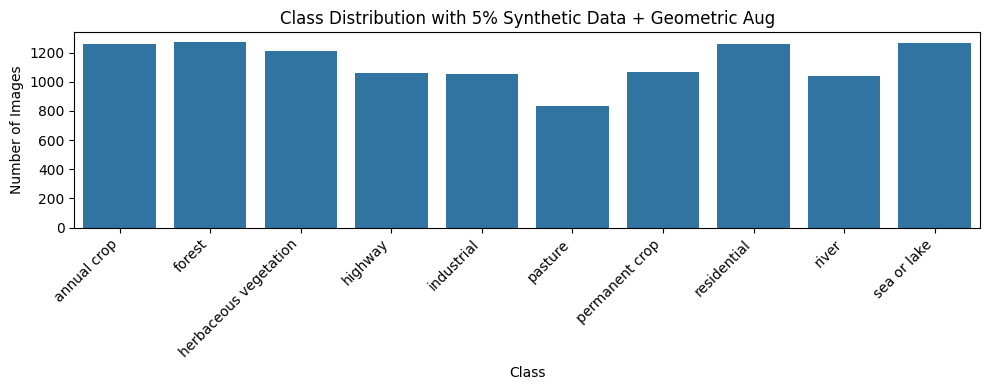

                   Class Percentage  Number of Images
0            annual crop     11.12%              1261
1                 forest     11.26%              1276
2  herbaceous vegetation     10.68%              1211
3                highway      9.35%              1060
4             industrial      9.31%              1055
5                pasture      7.38%               836
6         permanent crop      9.41%              1067
7            residential     11.13%              1262
8                  river      9.16%              1038
9            sea or lake     11.20%              1269
Epoch 1/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.3554, Train Acc: 0.8881, Train F1: 0.8889
Val Loss: 0.1388, Val Acc: 0.9570, Val F1: 0.9566
Epoch 2/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1626, Train Acc: 0.9452, Train F1: 0.9452
Val Loss: 0.1052, Val Acc: 0.9663, Val F1: 0.9662
Epoch 3/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1243, Train Acc: 0.9569, Train F1: 0.9569
Val Loss: 0.1092, Val Acc: 0.9644, Val F1: 0.9645
Epoch 4/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1034, Train Acc: 0.9659, Train F1: 0.9659
Val Loss: 0.0760, Val Acc: 0.9722, Val F1: 0.9722
Epoch 5/30


Training:   0%|          | 0/178 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Main execution
def run_combined_geo_synth_experiments():
    # Define transformations

    # 1. Basic transformation (no augmentation)
    transform_basic = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Geometric augmentation
    transform_geometric = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Standard test transformation (no augmentation)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create base datasets
    geo_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_geometric)
    val_dataset = EuroSATDataset(train_val_dataset, val_indices, transform_test)

    # Create validation dataloader (common for all experiments)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    # Extract synthetic dataset
    print("Extracting synthetic dataset...")
    zip_path = "/content/drive/MyDrive/data/ddpm-generated-images_50.zip"
    extract_path = "/content/ddpm_generated"

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
    except Exception as e:
        print(f"Error extracting synthetic dataset: {e}")
        print("Make sure the path is correct and the file exists")
        return

    # Load synthetic data with geometric augmentation
    synthetic_geo = ImageFolder(
        root=extract_path,
        transform=transform_geometric
    )

    # Define different augmentation ratios
    synth_ratios = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50]

    # Store results
    all_results = {
        'experiment': [],
        'best_val_acc': []
    }

    # Run experiments with different synthetic data ratios + geometric augmentation
    for ratio in synth_ratios:
        print(f"\n=========================================")
        print(f"Running experiment: {int(ratio*100)}% Synthetic Data + Geometric Augmentation")
        print(f"=========================================")

        # Create dataset with synthetic data and apply geometric augmentation to both real and synthetic data
        combined_geo_dataset = create_synthetic_dataset(geo_train_dataset, synthetic_geo, ratio)
        train_loader = DataLoader(combined_geo_dataset, batch_size=64, shuffle=True, num_workers=0)

        # Check class distribution
        combined_geo_labels = [label for _, label in combined_geo_dataset]
        df = plot_class_distribution(combined_geo_labels, f"Class Distribution with {int(ratio*100)}% Synthetic Data + Geometric Aug")
        print(df)

        model = ResNet18Classifier(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

        _, best_acc = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            save_path=f"/content/drive/MyDrive/models/resnet18_geo_synth_{int(ratio*100)}pct.pth"
        )

        all_results['experiment'].append(f"{int(ratio*100)}% Synthetic Data + Geo Aug")
        all_results['best_val_acc'].append(best_acc)

    # Plot final results
    results_df = pd.DataFrame(all_results)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='experiment', y='best_val_acc')
    plt.title('Validation Accuracy with Combined Geometric + Synthetic Augmentation')
    plt.ylabel('Validation Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/results/geo_synth_augmentation_comparison.png')
    plt.show()

    print("Final results:")
    print(results_df)

    # Save results to CSV
    results_df.to_csv('/content/drive/MyDrive/results/geo_synth_augmentation_results.csv', index=False)

    return results_df

# Run only the combined geometric + synthetic experiments
if __name__ == "__main__":
    results = run_combined_geo_synth_experiments()